In [7]:

#* Dane 30tyś iteracji
#* Wystapienie awarii po 20tyś iteracji
    
#* Wen, Qingsong, et al. "Transformers in Time Series: A Survey." arXiv preprint arXiv:2202.07125 (2022).
#* https://arxiv.org/pdf/2202.07125.pdf

#* Online Machine Learning
#* https://analyticsindiamag.com/how-to-learn-from-streaming-data-with-creme-in-python/

#* Timeseries Forecasting
#* https://www.tensorflow.org/tutorials/structured_data/time_series

In [8]:

#* Czy każdy model powinien być wyuczony dla jednego połączenia

#* Czy w ramach predykcji powinniśmy analizować działanie także model zaczyna predykcje od N ostatnich próbek

#* Następnie w każdym kolejnym kroku wykorzystuje poprzednie N-1 próbek oraz ostatnio przewidzianą próbkę
#* W ten sposób po N krokach każda kolejna predykcja będzie wykonywana na podstawie jedynie przewidzianych próbek
#* Bez udziału próbek realnych

In [1]:
# Utility imports
import os
import tqdm
from collections import defaultdict

# Math and matrix manipulation imports
import numpy as np
import pandas as pd

# Graphing imports
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers
from tensorflow.python.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_percentage_error

2022-05-09 01:42:40.983019: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-09 01:42:40.983109: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Tensorflow required
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), 'Physical GPUs,', len(logical_gpus), 'Logical GPUs')
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

2022-05-09 01:42:57.051966: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 01:42:57.053071: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-09 01:42:57.053180: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-05-09 01:42:57.053254: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-05-09 01:42:57.053324: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [3]:
DATA_PATH = "./datasets/traffic/"
# Lista pozwalajaca zobaczyc skladowe generowanego sygnalu
list_of_datafiles = os.listdir(DATA_PATH)
list_of_datafiles = sorted([int(x.replace('.txt', '')) for x in list_of_datafiles])

In [4]:
type(list_of_datafiles[0])

int

In [5]:
df = defaultdict(list)

# TODO: Zmienic w funkcje
# TODO: Dodac multiprocessing
for file in tqdm.tqdm(list_of_datafiles):
    temp = np.loadtxt(f"{DATA_PATH}{str(file)}.txt")
    #temp = np.loadtxt(f"{DATA_PATH}{file}")
    df['5->8'].append(temp[5][8])
    df['8->5'].append(temp[8][5])
    df['5->12'].append(temp[5][12])
    df['8->12'].append(temp[8][12])

del temp

100%|██████████| 30000/30000 [00:10<00:00, 2791.57it/s]


In [6]:
df = pd.DataFrame.from_dict(df)
train_df = df[:20000]
test_df = df[20000:].reset_index().drop('index', axis=1)

In [7]:
train_df.head()

,5->8,8->5,5->12,8->12
0,687.203,333.742,316.462,200.131
1,699.149,344.157,243.256,200.265
2,711.016,354.551,187.275,200.398
3,722.761,364.881,153.995,200.529
4,734.340,375.105,146.680,200.658


In [8]:
df.shape[0]

30000

In [9]:
test_df.head()

,5->8,8->5,5->12,8->12
0,0.0,501.780,0.0,714.854
1,0.0,495.681,0.0,661.079
2,0.0,489.578,0.0,589.308
3,0.0,483.474,0.0,506.632
4,0.0,477.368,0.0,421.274


Text(0.5, 1.0, 'Test dataset')

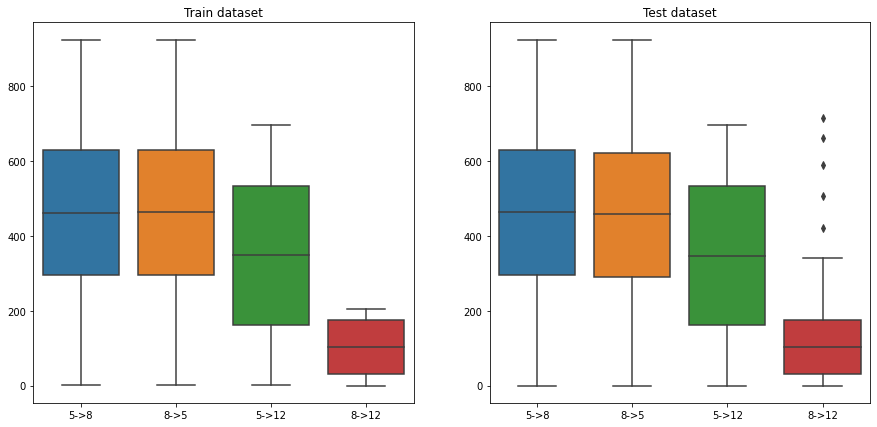

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(15,7))
sns.boxplot(data=train_df, ax=axs[0])
sns.boxplot(data=test_df, ax=axs[1])
axs[0].set_title('Train dataset')
axs[1].set_title('Test dataset')

In [11]:
def plot_data(target: str):
    fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(30,7))
    sns.lineplot(data=train_df, x=np.arange(0, train_df.shape[0], 1), y=target, ax=axs[0]).set_title(f"Wizualizacja zbioru treningowego {target}")
    sns.lineplot(data=test_df, x=np.arange(0, test_df.shape[0], 1), y=target, ax=axs[1]).set_title(f"Wizualizacja zbioru testowego {target}")
    sns.lineplot(data=df, x=np.arange(0, df.shape[0], 1), y=target, ax=axs[2]).set_title(f"Wizualizacja całego zbioru {target}")

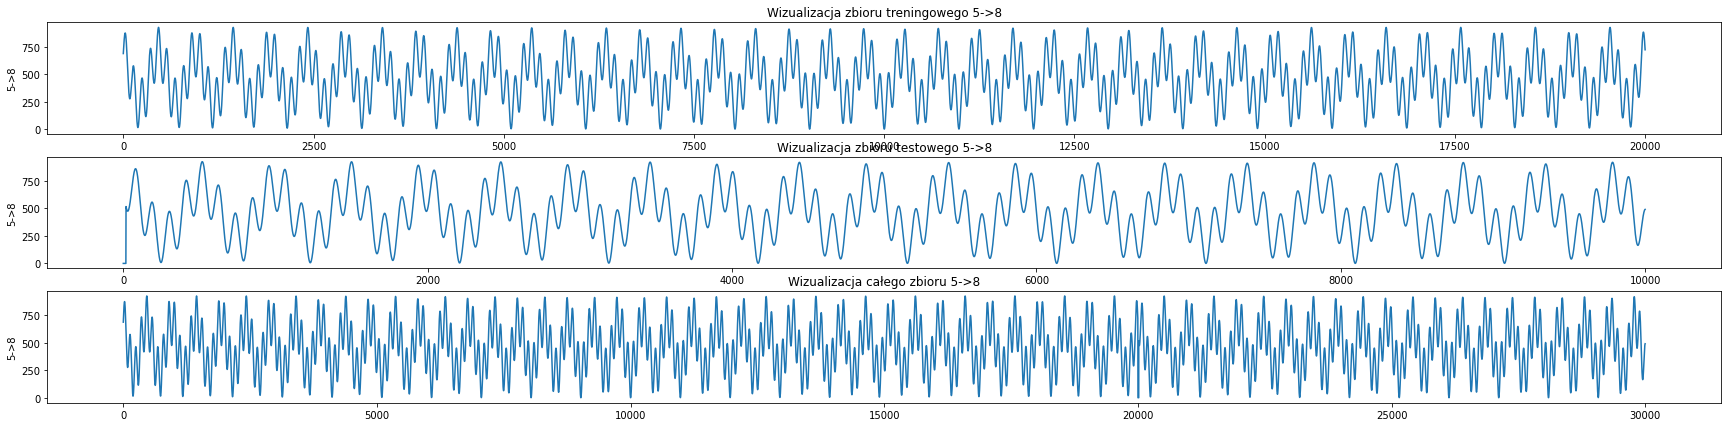

In [12]:
plot_data('5->8')

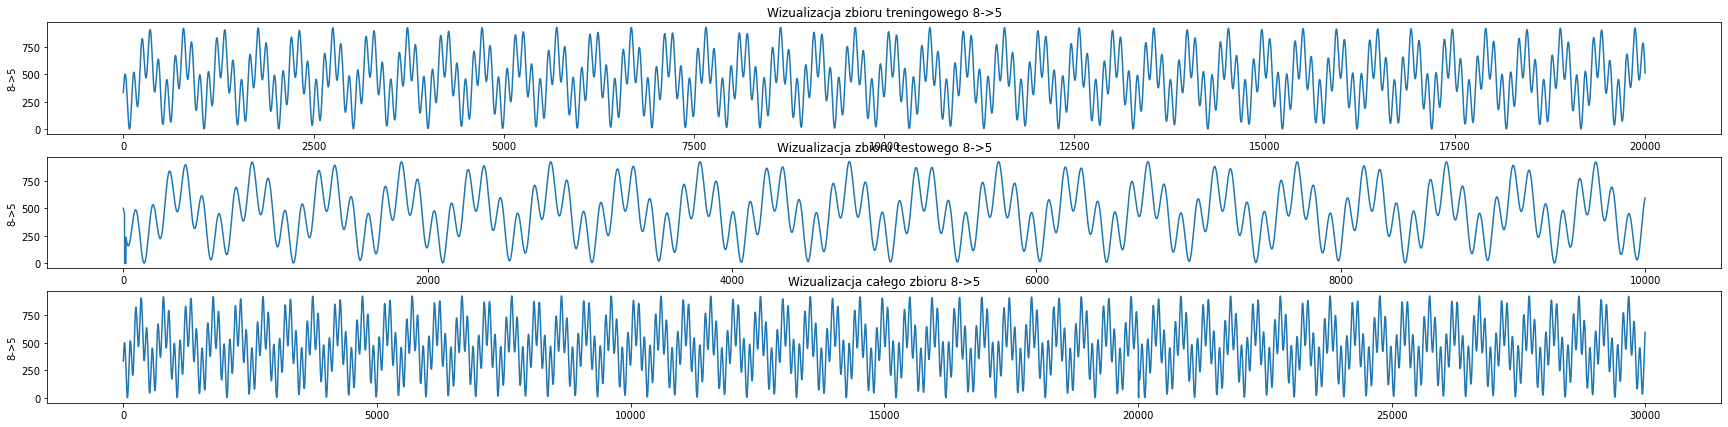

In [13]:
plot_data('8->5')

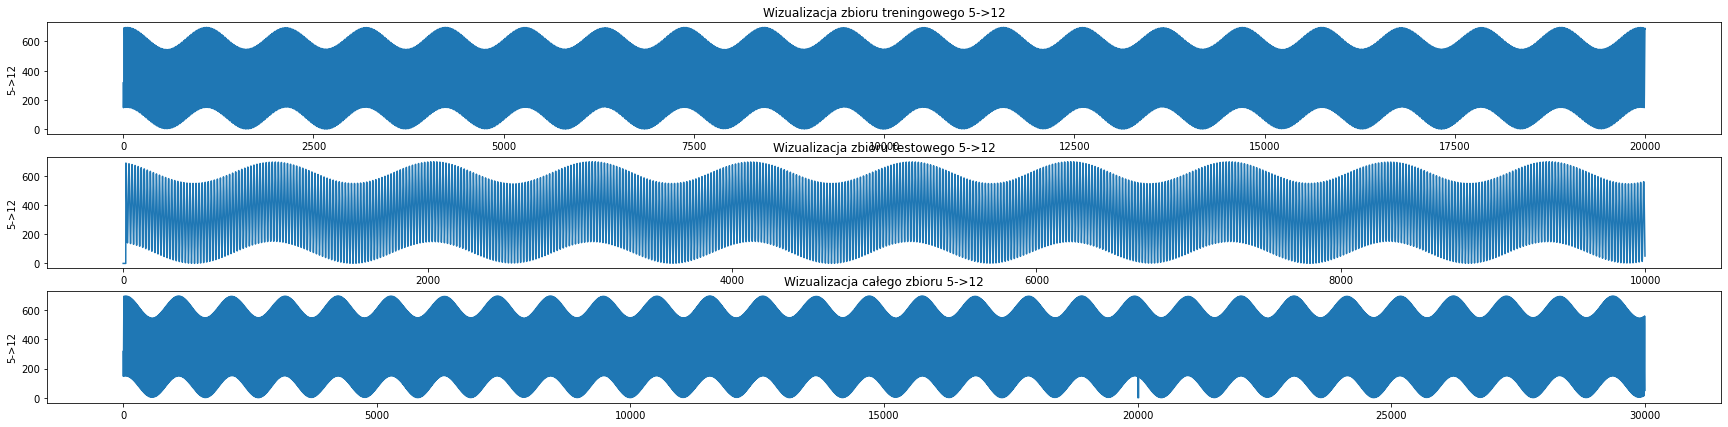

In [14]:
plot_data('5->12')

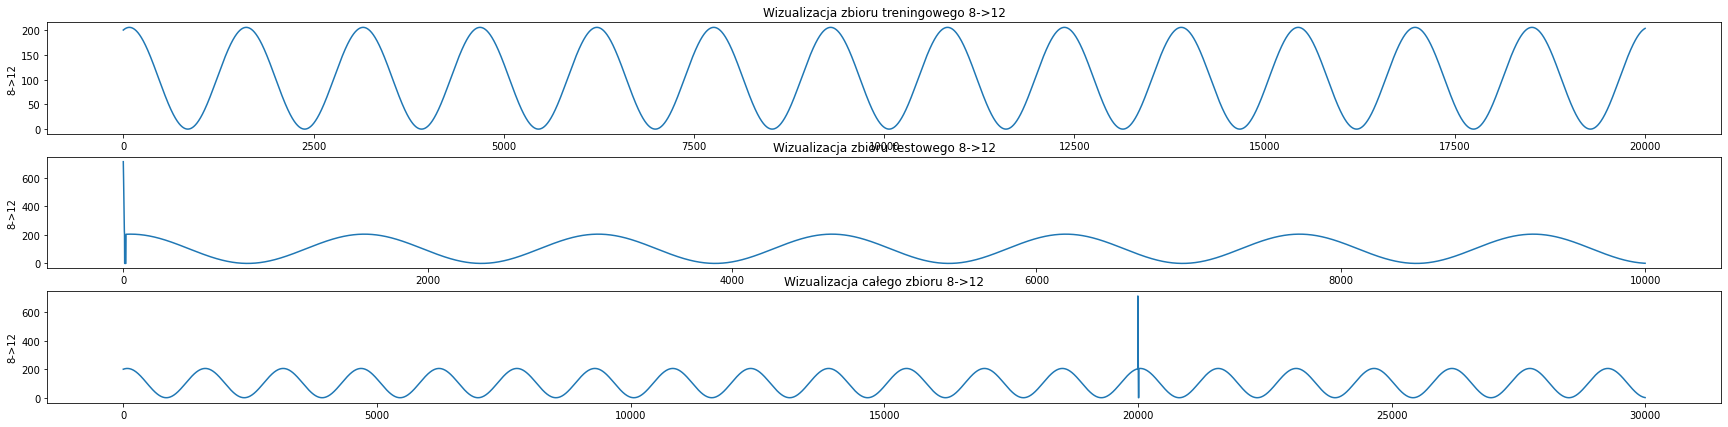

In [15]:
plot_data('8->12')

In [22]:
train_df.describe()

,5->8,8->5,5->12,8->12
count,20000.000000,20000.000000,20000.000000,20000.000000
mean,462.570189,463.285939,348.692120,102.947358
std,231.732590,231.486416,200.797896,72.734316
min,0.027211,0.030253,0.032017,0.000006
25%,295.331500,296.964750,162.787500,30.125700
50%,461.899000,463.749500,348.113000,103.181000
75%,629.643250,630.028250,534.142750,175.749000
max,925.484000,925.484000,696.640000,205.577000


In [23]:
test_df.describe()

,5->8,8->5,5->12,8->12
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,462.820913,458.509907,346.438135,103.642409
std,231.689384,231.994807,201.131697,73.563424
min,0.000000,0.000000,0.000000,0.000000
25%,296.655500,290.694750,160.895750,30.722800
50%,464.395500,457.843000,346.279500,103.658000
75%,630.123500,622.672500,532.785750,176.338000
max,924.507000,925.467000,696.640000,714.854000


In [16]:
def split_sequence(*, sequence, n_input_steps=5, n_output_steps=1):
    X, y = list(), list()
    for i in range(sequence.shape[0]):
        if i + n_input_steps + n_output_steps < len(sequence) + 1:
            seq_x, seq_y = list(sequence[i:i+n_input_steps]), list(sequence[i+n_input_steps:i+n_input_steps+n_output_steps])
            X.append(seq_x)
            y.append(seq_y)
    return np.array(X), np.array(y)

In [36]:
n_input_steps = 1
n_output_steps = 1
#target = '5->8'
#target = '8->5'
target = '5->12'
#target = '8->12'
X_train, y_train = split_sequence(sequence = train_df[target], n_input_steps=n_input_steps, n_output_steps=n_output_steps)
X_test, y_test = split_sequence(sequence = test_df[target], n_input_steps=n_input_steps, n_output_steps=n_output_steps)

In [37]:
X_train.shape

(19999, 1)

In [38]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [39]:

# TODO: Zmodyfikować tworzenie zbioru w taki sposób, aby funkcja train_model sama wybierała poprawny cel tj. '5->8', '8->5' itd.
def build_model(n_input_steps: int, n_output_steps: int, n_features: int, *, model_type: str) -> tf.keras.Model:
    model_types = ['LSTM']
    if model_type in model_types:
        if model_type == 'LSTM':
            model = keras.Sequential()
            model.add(layers.LSTM(50, activation='relu', input_shape=(n_input_steps, n_features)))
            model.add(layers.Dense(n_output_steps))
            model.compile(optimizer='adam', loss='mse')
    else:
        print('Model niedostępny')
        return
    
    return model

# TODO: Dodać podział na zbiór walidacyjny i testowy?
def train_model(input_data: np.array, input_target: str, output_data: np.array, output_target: str, 
                model_type: str, epochs: int = 20, verbose: int = 1, early_stopping: bool = True) -> str:
    n_input_steps = input_data.shape[1]
    n_output_steps = output_data.shape[1]
    n_features = input_data.shape[2]

    models_path = './saved_models/'

    if not os.path.exists(models_path):
        os.mkdir(models_path)

    saved_models = os.listdir(models_path)
    model_name = f'{model_type}_{input_target}to{output_target}_in{str(n_input_steps)}_out{str(n_output_steps)}'
    model_path = f'{models_path}{model_name}'
    target = f'{input_target}->{output_target}'

    if model_name not in saved_models:
        es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=3)
        model = build_model(n_input_steps=n_input_steps, n_output_steps=n_output_steps, n_features=n_features, 
                            model_type=model_type)
        model.fit(input_data, output_data, epochs=20, verbose=1, callbacks=[es])
        model.save(model_path)
        del model

        print('Zakończono trening i zapis modelu ')
        print(f'Wczytano ścieżkę modelu: {model_path}\n')

    else:
        print(f'Model {model_name} już istnieje')
        print(f'Wczytano ścieżkę modelu: {model_path}')
        print('W celu wytrenowania nowego modelu należy ręcznie usunąć zapisane pliki\n')

    return model_path

def test_model(input_data: np.array, output_data: np.array, model_path: str = None, model_type: str = None):
    if model_path is None and model_type is None:
        print('Nie wybrano żadnego modelu')
        print('Podaj ścieżkę do modelu lub wybierz typ modelu')
        return
    elif model_path is not None and model_type is not None:
        print('Wybrano zbyt wiele modeli')
        print('Podaj ścieżkę do modelu lub wybierz typ modelu')
        return

    elif model_path is not None and model_type is None:
        model = tf.keras.models.load_model(model_path)
        y_pred = model.predict(input_data, verbose=0)

    elif model_path is None and model_type is not None:
        return
    

    print(f'MAPE: {smape(output_data, y_pred)}')
    for i in range(len(output_data)):
        print(f"real: {output_data[i]} | pred: {y_pred[i]}")

    figure = plt.figure(figsize = (20, 15))
    ax = plt.subplot(111)
    line = ax.plot(np.arange(0, output_data.shape[0], 1), output_data, 'r', linewidth=5)
    line2 = ax.plot(np.arange(0, y_pred.shape[0], 1), y_pred, 'b', linewidth=1)

    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=2)

    plt.show()

def smape(A, F):
    tmp = 2 * np.abs(F - A) / (np.abs(A) + np.abs(F))
    len_ = np.count_nonzero(~np.isnan(tmp))
    if len_ == 0 and np.nansum(tmp) == 0: # Deals with a special case
        return 100
    return 100 / len_ * np.nansum(tmp)

Epoch 1/20
625/625 [==============================] - 5s 3ms/step - loss: 22414.1660
Epoch 2/20
625/625 [==============================] - 2s 2ms/step - loss: 3614.8591
Epoch 3/20
625/625 [==============================] - 2s 2ms/step - loss: 3610.0498
Epoch 4/20
625/625 [==============================] - 2s 2ms/step - loss: 3611.8918
Epoch 5/20
625/625 [==============================] - 2s 3ms/step - loss: 3611.0059
Epoch 6/20
625/625 [==============================] - 2s 2ms/step - loss: 3609.6370
Epoch 7/20
625/625 [==============================] - 2s 2ms/step - loss: 3615.1748
Epoch 8/20
625/625 [==============================] - 2s 2ms/step - loss: 3605.6350
Epoch 9/20
625/625 [==============================] - 2s 2ms/step - loss: 3610.9573
Epoch 10/20
625/625 [==============================] - 2s 3ms/step - loss: 3608.3508
Epoch 11/20
625/625 [==============================] - 2s 3ms/step - loss: 3617.0913
Epoch 00011: early stopping


2022-05-09 01:52:43.902147: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./saved_models/LSTM_5to12_in1_out1/assets


INFO:tensorflow:Assets written to: ./saved_models/LSTM_5to12_in1_out1/assets


Zakończono trening i zapis modelu 
Wczytano ścieżkę modelu: ./saved_models/LSTM_5to12_in1_out1

MAPE: 24.78567493577089
real: [0.] | pred: [3.5283928]
real: [0.] | pred: [3.5283928]
real: [0.] | pred: [3.5283928]
real: [0.] | pred: [3.5283928]
real: [0.] | pred: [3.5283928]
real: [0.] | pred: [3.5283928]
real: [0.] | pred: [3.5283928]
real: [0.] | pred: [3.5283928]
real: [0.] | pred: [3.5283928]
real: [0.] | pred: [3.5283928]
real: [0.] | pred: [3.5283928]
real: [0.] | pred: [3.5283928]
real: [0.] | pred: [3.5283928]
real: [0.] | pred: [3.5283928]
real: [0.] | pred: [3.5283928]
real: [0.] | pred: [3.5283928]
real: [0.] | pred: [3.5283928]
real: [687.226] | pred: [3.5283928]
real: [683.117] | pred: [667.77386]
real: [652.776] | pred: [663.8008]
real: [599.137] | pred: [634.46313]
real: [527.545] | pred: [582.59796]
real: [444.759] | pred: [513.37335]
real: [359.081] | pred: [433.3251]
real: [278.604] | pred: [350.4804]
real: [211.308] | pred: [272.66473]
real: [163.807] | pred: [208.407

real: [32.248] | pred: [13.0116825]
real: [81.7906] | pred: [43.843334]
real: [150.466] | pred: [91.601585]
real: [231.86] | pred: [153.65979]
real: [317.551] | pred: [227.46654]
real: [399.44] | pred: [310.3238]
real: [469.753] | pred: [389.50476]
real: [521.22] | pred: [457.49255]
real: [549.079] | pred: [507.25757]
real: [550.595] | pred: [534.19525]
real: [525.626] | pred: [535.66113]
real: [476.669] | pred: [511.51782]
real: [408.511] | pred: [464.17984]
real: [327.549] | pred: [398.2758]
real: [242.191] | pred: [319.99115]
real: [160.536] | pred: [237.4559]
real: [90.3693] | pred: [162.95683]
real: [38.9788] | pred: [98.72458]
real: [11.1514] | pred: [51.120438]
real: [9.65404] | pred: [18.939054]
real: [34.6618] | pred: [16.995956]
real: [83.708] | pred: [46.48941]
real: [152.032] | pred: [93.226944]
real: [233.257] | pred: [155.11171]
real: [318.985] | pred: [228.81735]
real: [401.118] | pred: [311.71036]
real: [471.863] | pred: [391.1273]
real: [523.91] | pred: [459.53278]
rea

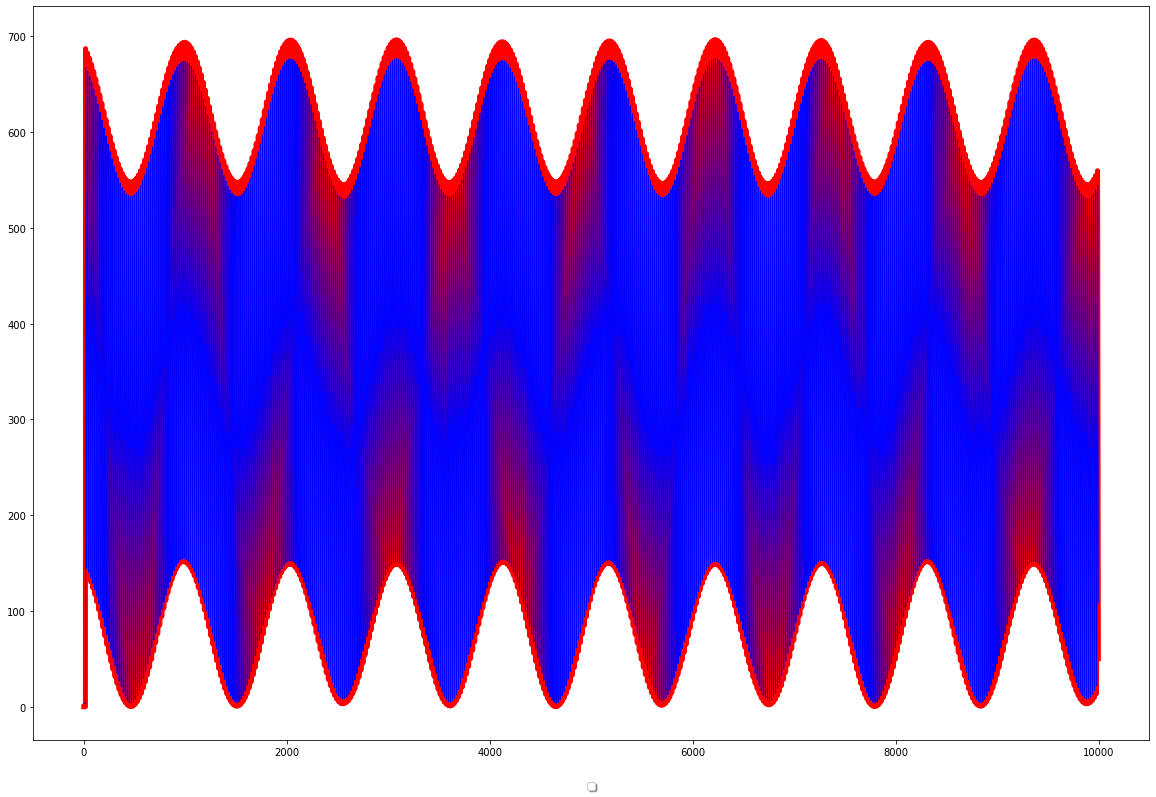

In [40]:
model_path = train_model(input_data=X_train, input_target=5, output_data=y_train, output_target=12, model_type='LSTM')
test_model(input_data=X_test, output_data=y_test, model_path=model_path)

In [41]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train.reshape((X_train.shape[0], X_train.shape[1])), y_train)

In [42]:
y_pred = reg.predict(X_test.reshape((X_test.shape[0], X_test.shape[1])))

In [43]:
print(f'MAPE: {smape(y_test, y_pred):.6f}')

MAPE: 24.415229


In [44]:
for i in range(len(y_test)):
    print(f"real: {y_test[i]} | pred: {y_pred[i]}")

real: [0.] | pred: [15.84713408]
real: [0.] | pred: [15.84713408]
real: [0.] | pred: [15.84713408]
real: [0.] | pred: [15.84713408]
real: [0.] | pred: [15.84713408]
real: [0.] | pred: [15.84713408]
real: [0.] | pred: [15.84713408]
real: [0.] | pred: [15.84713408]
real: [0.] | pred: [15.84713408]
real: [0.] | pred: [15.84713408]
real: [0.] | pred: [15.84713408]
real: [0.] | pred: [15.84713408]
real: [0.] | pred: [15.84713408]
real: [0.] | pred: [15.84713408]
real: [0.] | pred: [15.84713408]
real: [0.] | pred: [15.84713408]
real: [0.] | pred: [15.84713408]
real: [687.226] | pred: [15.84713408]
real: [683.117] | pred: [671.87545852]
real: [652.776] | pred: [667.95299286]
real: [599.137] | pred: [638.98936897]
real: [527.545] | pred: [587.78539343]
real: [444.759] | pred: [519.44342179]
real: [359.081] | pred: [440.4156189]
real: [278.604] | pred: [358.62710278]
real: [211.308] | pred: [281.8034793]
real: [163.807] | pred: [217.56248417]
real: [140.576] | pred: [172.21786473]
real: [143.93

In [ ]:
#from collections import defaultdict
#from functools import partial

#new_dict = defaultdict(lambda: numpy.zeros(array_size))
#defaultdict(partial(numpy.ndarray, 0))

In [65]:
from typing import List, Union

list_of_int = [1, 2, 3]
list_of_str = ['1', '2', '3']

TypeError: Subscripted generics cannot be used with class and instance checks

In [71]:
from typeguard import check_type

try:
    check_type('list_of_int', list_of_int, List[int])
    print("string_list conforms to string_list_class")
except TypeError:
    print("string_list does not conform to string_list_class")

string_list conforms to string_list_class


In [76]:
check_type('list_of_int', list_of_int, List[int])
